Semester Project: Cellular Device Classification
================================================

Authors: Calvin Henggeler, Heeirthan Shanthan, Aspen Smith

DS-312 Machine Learning

Fall 2023

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import resample
from multiprocessing import Pool
from itertools import product

## Loading the Data

In [3]:
paths = [
    ("../../data/LTE_data/bus", "bus"),
    ("../../data/LTE_data/car", "car"),
    ("../../data/LTE_data/pedestrian", "pedestrian"),
    ("../../data/LTE_data/static", "static"),
    ("../../data/LTE_data/train", "train")
]

filenames = []
for path, label in paths:
    filenames.extend([(filename, label) for filename in glob.glob(os.path.join(path, "*.csv"))])

Lis = []
for filename, label in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['path'] = label
    Lis.append(df)

LTE_data = pd.concat(Lis, axis=0, ignore_index=True)
LTE_data

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,path
0,2017.11.30_16.48.26,-8.501373,51.893359,0,A,2,LTE,-102,-12,10.0,...,-85,3,7,D,-,-,-8.491719,51.893905,665.24000000000001,bus
1,2017.11.30_16.48.26,-8.501291,51.893462,1,A,2,LTE,-102,-12,10.0,...,-85,3,7,D,-,-,-8.491719,51.893905,658.67999999999995,bus
2,2017.11.30_16.48.27,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,-87,310,14,D,-,-,-8.491719,51.893905,658.67999999999995,bus
3,2017.11.30_16.48.28,-8.501291,51.893462,1,A,2,LTE,-102,-12,7.0,...,-85,0,0,I,-,-,-8.491719,51.893905,658.67999999999995,bus
4,2017.11.30_16.48.29,-8.501291,51.893462,1,A,2,LTE,-102,-13,8.0,...,-85,0,0,I,-,-,-8.491719,51.893905,658.67999999999995,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174518,2018.02.05_15.24.28,-8.490956,51.934883,74,B,1,LTE,-102,-12,8.0,...,-85,35453,646,D,-109.0,-18.0,-8.489758,51.928426,722.66999999999996,train
174519,2018.02.05_15.24.29,-8.490956,51.934883,74,B,1,LTE,-101,-12,9.0,...,-85,37746,684,D,-,-,-8.489758,51.928426,722.66999999999996,train
174520,2018.02.05_15.24.30,-8.490956,51.934883,74,B,1,LTE,-101,-12,9.0,...,-82,40530,723,D,-,-,-8.489758,51.928426,722.66999999999996,train
174521,2018.02.05_15.24.31,-8.490956,51.934883,74,B,1,LTE,-100,-12,12.0,...,-,43103,756,D,-,-,-8.489758,51.928426,722.66999999999996,train


In [4]:
LTE_data.describe()

,Longitude,Latitude,Speed,CellID,RSRP,DL_bitrate,UL_bitrate
count,174523.000000,174523.000000,174523.000000,174523.000000,174523.000000,174523.000000,174523.000000
mean,-8.441232,52.017980,30.530429,4563.573741,-91.517542,10822.324427,184.749529
std,0.419659,0.306211,38.297034,12035.047726,16.342720,14149.653859,220.538218
min,-9.589915,51.871394,0.000000,0.000000,-200.000000,0.000000,0.000000
25%,-8.505997,51.893450,0.000000,2.000000,-102.000000,1386.000000,32.000000
50%,-8.488805,51.899414,17.000000,2.000000,-93.000000,5370.000000,107.000000
75%,-8.459378,51.935595,46.000000,8.000000,-82.000000,14796.000000,266.000000
max,-6.295653,53.346380,166.000000,65353.000000,-27.000000,173016.000000,4178.000000


In [5]:
LTE_data.columns

Index(['Timestamp', 'Longitude', 'Latitude', 'Speed', 'Operatorname', 'CellID',
       'NetworkMode', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate',
       'UL_bitrate', 'State', 'NRxRSRP', 'NRxRSRQ', 'ServingCell_Lon',
       'ServingCell_Lat', 'ServingCell_Distance', 'path'],
      dtype='object')

In [6]:
# Enumerate non numerical Data
target_dict = {'LTE':   1,
               'HSPA+': 2,
               'HSUPA': 3,
               'UMTS':  4,
               'EDGE':  5,
               'HSDPA': 6,
               'GPRS':  7}

LTE_data['NetworkMode'] = LTE_data['NetworkMode'].map(target_dict)
LTE_data['NetworkMode'].value_counts()

# Convert Idle or Download state to numeric
LTE_data.loc[LTE_data['State'] == 'D', 'State'] = 1
LTE_data.loc[LTE_data['State'] == 'I', 'State'] = 0

# Replace the '-' character with Nan, Does not affect negative values
LTE_data.replace('-', np.NaN, inplace=True)
LTE_data

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,path
0,2017.11.30_16.48.26,-8.501373,51.893359,0,A,2,1,-102,-12,10.0,...,-85,3,7,1,NaN,NaN,-8.491719,51.893905,665.24000000000001,bus
1,2017.11.30_16.48.26,-8.501291,51.893462,1,A,2,1,-102,-12,10.0,...,-85,3,7,1,NaN,NaN,-8.491719,51.893905,658.67999999999995,bus
2,2017.11.30_16.48.27,-8.501291,51.893462,1,A,2,1,-102,-12,7.0,...,-87,310,14,1,NaN,NaN,-8.491719,51.893905,658.67999999999995,bus
3,2017.11.30_16.48.28,-8.501291,51.893462,1,A,2,1,-102,-12,7.0,...,-85,0,0,0,NaN,NaN,-8.491719,51.893905,658.67999999999995,bus
4,2017.11.30_16.48.29,-8.501291,51.893462,1,A,2,1,-102,-13,8.0,...,-85,0,0,0,NaN,NaN,-8.491719,51.893905,658.67999999999995,bus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174518,2018.02.05_15.24.28,-8.490956,51.934883,74,B,1,1,-102,-12,8.0,...,-85,35453,646,1,-109.0,-18.0,-8.489758,51.928426,722.66999999999996,train
174519,2018.02.05_15.24.29,-8.490956,51.934883,74,B,1,1,-101,-12,9.0,...,-85,37746,684,1,NaN,NaN,-8.489758,51.928426,722.66999999999996,train
174520,2018.02.05_15.24.30,-8.490956,51.934883,74,B,1,1,-101,-12,9.0,...,-82,40530,723,1,NaN,NaN,-8.489758,51.928426,722.66999999999996,train
174521,2018.02.05_15.24.31,-8.490956,51.934883,74,B,1,1,-100,-12,12.0,...,NaN,43103,756,1,NaN,NaN,-8.489758,51.928426,722.66999999999996,train


In [7]:
LTE_data['NetworkMode'].value_counts()

NetworkMode
1    120824
2     42806
3      8039
4      1607
5      1240
6         5
7         2
Name: count, dtype: int64

In [8]:
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'State','ServingCell_Distance']
target = ['NetworkMode']

df = LTE_data[features + target]
df.shape

(174523, 11)

In [9]:
# Drop Nan
df = df.dropna()
df.shape

(102457, 11)

In [10]:
# Check variation in data target
df['NetworkMode'].value_counts()

NetworkMode
1    102457
Name: count, dtype: int64

We have lost alot of other observations that had the other target variables after dropna(). We will have to either use other features downsample or fill in the data. For now we will use the features that are common accross most observations.

### Feature Engineering

In [11]:
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI', 'DL_bitrate', 'UL_bitrate', 'State','ServingCell_Distance']
target = ['NetworkMode']
df = LTE_data[features + target]

In [12]:
# Ensure all numeric Data
df = df[features+target].astype(float)

In [13]:
# Check for columns that contain string data, we should not have any at this point
string_columns = [col for col in df.columns if df[col].dtype == 'O']

# Print the result
if string_columns:
    print("Columns with string values:", string_columns)
else:
    print("No columns with string values found.")

No columns with string values found.


The last amount of the last two instances of the target variable are so small that they can effectivly be ommited.

In [14]:
# Drop the rows of these target variables
df = df[df['NetworkMode'] != target_dict['HSDPA']]
df = df[df['NetworkMode'] != target_dict['GPRS']]

In [15]:
df.describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,174516.000000,174516.000000,173281.000000,120800.000000,120803.000000,109460.000000,174516.000000,174516.000000,174516.000000,123941.000000,174516.000000
mean,30.528152,-91.518004,-9.538495,5.350894,8.017880,-79.915805,10822.671451,184.754647,0.918712,5639.315333,1.393460
std,38.296044,16.342506,5.419395,8.045561,3.037512,11.049441,14149.828805,220.541046,0.273277,15885.997526,0.686509
min,0.000000,-200.000000,-24.000000,-30.000000,1.000000,-94.000000,0.000000,0.000000,0.000000,25.420000,1.000000
25%,0.000000,-102.000000,-14.000000,0.000000,6.000000,-89.000000,1386.000000,32.000000,1.000000,453.920000,1.000000
50%,17.000000,-93.000000,-12.000000,5.000000,8.000000,-81.000000,5378.000000,107.000000,1.000000,758.620000,1.000000
75%,46.000000,-82.000000,-2.000000,10.000000,10.000000,-73.000000,14796.000000,266.000000,1.000000,1677.850000,2.000000
max,166.000000,-27.000000,7.000000,33.000000,15.000000,-36.000000,173016.000000,4178.000000,1.000000,222739.980000,5.000000


SNR, RSSI, RSSI, and ServingCell_Distance are missing significant chuncks of data compared to the other feature. These are all usefull for calculations regarding RF quality in some formulas.

In [16]:
df[df['NetworkMode'] == target_dict['LTE']].describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,120824.000000,120824.000000,120822.000000,120791.000000,120794.000000,109458.000000,120824.000000,120824.000000,120824.000000,112758.000000,120824.0
mean,19.392488,-98.141743,-12.707934,5.351119,8.018296,-79.915703,13892.858513,231.442280,0.946219,4795.623841,1.0
std,28.193769,12.705763,2.730483,8.045695,3.037225,11.049516,15782.818936,243.469406,0.225585,14549.343067,0.0
min,0.000000,-200.000000,-24.000000,-30.000000,1.000000,-94.000000,0.000000,0.000000,0.000000,25.420000,1.0
25%,0.000000,-106.000000,-14.000000,0.000000,6.000000,-89.000000,2292.000000,50.000000,1.000000,425.390000,1.0
50%,3.000000,-99.000000,-13.000000,5.000000,8.000000,-81.000000,8533.000000,159.000000,1.000000,719.050000,1.0
75%,36.000000,-91.000000,-11.000000,10.000000,10.000000,-73.000000,19963.000000,340.000000,1.000000,1399.170000,1.0
max,162.000000,-27.000000,-2.000000,33.000000,15.000000,-36.000000,173016.000000,4178.000000,1.000000,222739.980000,1.0


In [17]:
df[df['NetworkMode'] == target_dict['HSPA+']].describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,42806.000000,42806.000000,42756.000000,4.000000,4.0,2.000000,42806.000000,42806.000000,42806.000000,8495.000000,42806.0
mean,55.774377,-77.301710,-2.206988,7.000000,2.0,-85.500000,3955.318437,82.091950,0.877424,13092.279665,2.0
std,44.338979,13.192325,1.728801,3.464102,0.0,0.707107,4596.954309,95.185633,0.327954,22490.603901,0.0
min,0.000000,-200.000000,-20.000000,2.000000,2.0,-86.000000,0.000000,0.000000,0.000000,121.230000,2.0
25%,23.000000,-87.000000,-2.000000,6.500000,2.0,-85.750000,402.000000,11.000000,1.000000,883.400000,2.0
50%,42.000000,-79.000000,-2.000000,8.000000,2.0,-85.500000,2349.000000,51.000000,1.000000,2381.750000,2.0
75%,91.000000,-67.000000,-2.000000,8.500000,2.0,-85.250000,5882.000000,118.000000,1.000000,10810.090000,2.0
max,166.000000,-51.000000,-2.000000,10.000000,2.0,-85.000000,30733.000000,880.000000,1.000000,119619.990000,2.0


In [18]:
df[df['NetworkMode'] == target_dict['HSUPA']].describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,8039.000000,8039.000000,8035.000000,3.000000,3.0,0.0,8039.000000,8039.000000,8039.000000,1577.000000,8039.0
mean,47.806817,-76.265580,-2.462726,-0.666667,2.0,NaN,4094.551188,76.027242,0.794377,14917.465187,3.0
std,48.827844,13.311314,2.425889,3.055050,0.0,NaN,4813.196893,86.022820,0.404181,28800.199110,0.0
min,0.000000,-200.000000,-20.000000,-4.000000,2.0,NaN,0.000000,0.000000,0.000000,211.580000,3.0
25%,0.000000,-87.000000,-2.000000,-2.000000,2.0,NaN,0.000000,1.000000,1.000000,647.560000,3.0
50%,41.000000,-75.000000,-2.000000,0.000000,2.0,NaN,2684.000000,52.000000,1.000000,888.660000,3.0
75%,85.000000,-65.000000,-2.000000,1.000000,2.0,NaN,5955.000000,115.000000,1.000000,7895.970000,3.0
max,154.000000,-51.000000,-2.000000,2.000000,2.0,NaN,31024.000000,648.000000,1.000000,155811.870000,3.0


In [19]:
df[df['NetworkMode'] == target_dict['UMTS']].describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,1607.000000,1607.000000,1602.000000,1.0,1.0,0.0,1607.000000,1607.000000,1607.000000,1110.000000,1607.0
mean,54.250156,-78.315495,-2.119226,1.0,6.0,NaN,4919.241444,94.632856,0.965775,21125.454252,4.0
std,43.909957,10.824107,1.199164,NaN,NaN,NaN,4382.823769,94.373451,0.181864,27709.746969,0.0
min,0.000000,-200.000000,-16.000000,1.0,6.0,NaN,0.000000,0.000000,0.000000,204.600000,4.0
25%,0.000000,-85.000000,-2.000000,1.0,6.0,NaN,1308.500000,23.000000,1.000000,1333.810000,4.0
50%,55.000000,-79.000000,-2.000000,1.0,6.0,NaN,3444.000000,62.000000,1.000000,12974.550000,4.0
75%,94.000000,-71.000000,-2.000000,1.0,6.0,NaN,8013.000000,144.000000,1.000000,21297.330000,4.0
max,122.000000,-51.000000,-2.000000,1.0,6.0,NaN,20030.000000,700.000000,1.000000,118663.920000,4.0


In [20]:
df[df['NetworkMode'] == target_dict['EDGE']].describe()

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,ServingCell_Distance,NetworkMode
count,1240.000000,1240.000000,66.000000,1.0,1.0,0.0,1240.000000,1240.000000,1240.000000,1.0,1240.0
mean,101.287097,-52.862097,1.560606,-6.0,2.0,NaN,4.770161,1.269355,0.408871,4416.0,5.0
std,37.141896,8.344742,2.987815,NaN,NaN,NaN,26.906701,8.397511,0.491824,NaN,0.0
min,0.000000,-104.000000,-15.000000,-6.0,2.0,NaN,0.000000,0.000000,0.000000,4416.0,5.0
25%,90.000000,-51.000000,0.000000,-6.0,2.0,NaN,0.000000,0.000000,0.000000,4416.0,5.0
50%,108.000000,-51.000000,1.000000,-6.0,2.0,NaN,0.000000,0.000000,0.000000,4416.0,5.0
75%,126.000000,-51.000000,3.750000,-6.0,2.0,NaN,0.000000,0.000000,1.000000,4416.0,5.0
max,164.000000,-51.000000,7.000000,-6.0,2.0,NaN,268.000000,216.000000,1.000000,4416.0,5.0


Will probably have to go without distance feature given that every target value is missing some and EDGE only has 1 of 1240 . SNR, CQI, and RSSI are also missing from everything but LTE so these will no be useful features for our experiment  

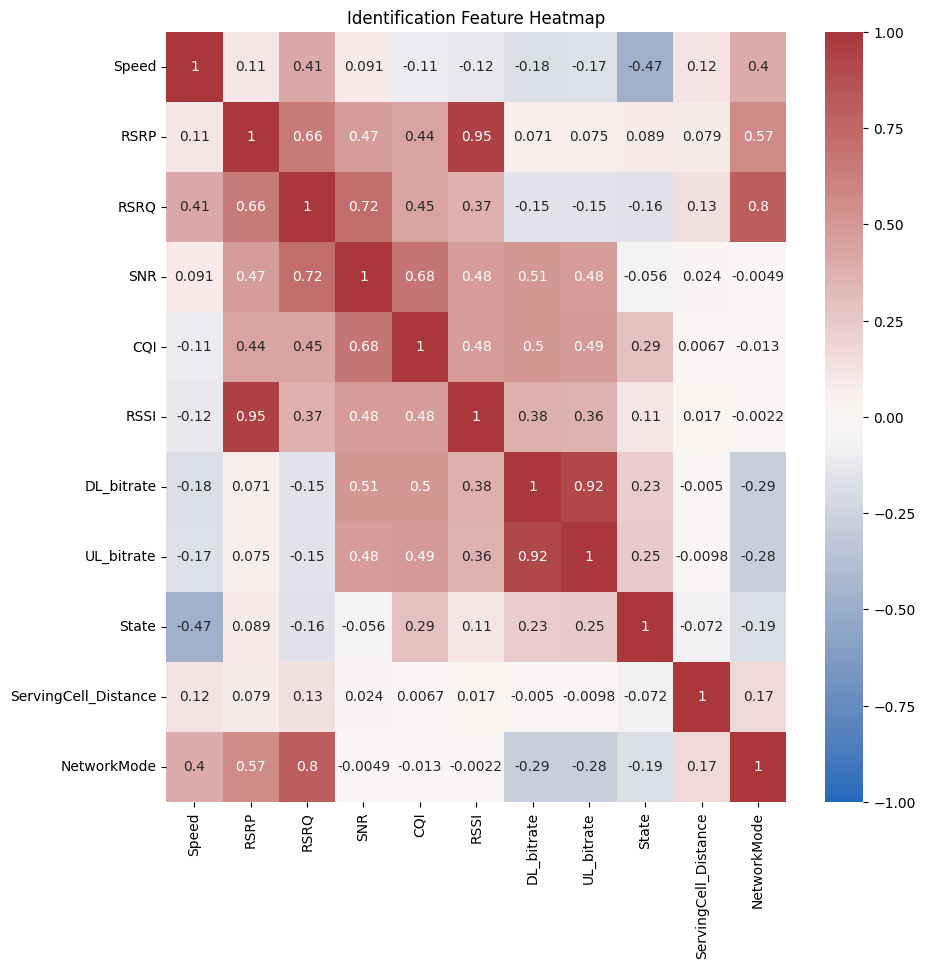

In [21]:
# Create Heatmap to see relationships between the original variables
fig,ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="vlag",annot = True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('Identification Feature Heatmap');

The identified network mode seems to be highly correlated with the RSRQ and RSRP variables. ServingCell_Distance seems to have very little correlation which supprts the argument of getting rid of it but it might be an informative feature when paired with others. We will keep it for now and drop EDGE. We will also drop all instances that do not have distance calculated.

In [22]:
# restate df with updated feature set
features = ['Speed', 'RSRP', 'RSRQ', 'DL_bitrate', 'UL_bitrate', 'State','ServingCell_Distance']
df = df[features + target]
# drop EDGE network mode
df = df[df['NetworkMode'] != target_dict['EDGE']]
# drop NaN in Distance for all other NetworkModes
df = df.dropna(subset=['ServingCell_Distance'])

In [23]:
df['NetworkMode'].value_counts()

NetworkMode
1.0    112758
2.0      8495
3.0      1577
4.0      1110
Name: count, dtype: int64

The data is extremely unbalanced so we will down sample all network types to the length of the shortest

In [24]:
balanced_df = pd.DataFrame()

In [25]:
for net_type in ['LTE', 'HSPA+', 'HSUPA', 'UMTS']:
    tempdf = df[df['NetworkMode']==target_dict[net_type]]
    net_type_downsamp = resample(tempdf, replace=False, n_samples=1110)
    balanced_df = pd.concat([balanced_df, net_type_downsamp])
balanced_df['NetworkMode'].value_counts()


NetworkMode
1.0    1110
2.0    1110
3.0    1110
4.0    1110
Name: count, dtype: int64

In [26]:
balanced_df.describe()
DF = balanced_df.dropna()

In [27]:
DF.columns

Index(['Speed', 'RSRP', 'RSRQ', 'DL_bitrate', 'UL_bitrate', 'State',
       'ServingCell_Distance', 'NetworkMode'],
      dtype='object')

In [28]:
# features = ['Speed', 'RSRP', 'RSRQ', 'DL_bitrate', 'UL_bitrate', 'State', 'ServingCell_Distance']
features = ['RSRP', 'RSRQ', 'DL_bitrate', 'UL_bitrate', 'State', 'ServingCell_Distance']

In [29]:
# 80% Train | 10% Validatoin | 10% Test
x_tr, x_temp, y_tr, y_temp = train_test_split(DF[features], DF[target], test_size=0.8)
x_te, x_va, y_te, y_va = train_test_split(x_temp, y_temp, test_size=0.5)

In [30]:
y_tr = y_tr.values.ravel()
y_va = y_va.values.ravel()

## ----- Multi-Layer Perceptron (MLP) Neural Network -----

In [30]:
"""
scores = []
layer_sizes = [10, 25 , 50, 100]
for size in layer_sizes:
    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=(size,size,size))
    MLPnn.fit(x_tr, y_tr)
    score = MLPnn.score(x_va, y_va)
    scores.append((size,score))
"""

"\nscores = []\nlayer_sizes = [10, 25 , 50, 100]\nfor size in layer_sizes:\n    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=(size,size,size))\n    MLPnn.fit(x_tr, y_tr)\n    score = MLPnn.score(x_va, y_va)\n    scores.append((size,score))\n"

In [31]:
"""
for size,score in scores:
    print(f'size:{size} achieved {score} accuracy')
"""

"\nfor size,score in scores:\n    print(f'size:{size} achieved {score} accuracy')\n"

In [32]:
"""
scores = []
depths = [(50,50),
          (50,50,50),
          (50,50,50,50,50),
          (50,50,50,50,50,50,50,50,50,50)]
for depth in depths:
    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=depth)
    MLPnn.fit(x_tr, y_tr)
    score = MLPnn.score(x_va, y_va)
    scores.append((depth,score))
"""

"\nscores = []\ndepths = [(50,50),\n          (50,50,50),\n          (50,50,50,50,50),\n          (50,50,50,50,50,50,50,50,50,50)]\nfor depth in depths:\n    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=depth)\n    MLPnn.fit(x_tr, y_tr)\n    score = MLPnn.score(x_va, y_va)\n    scores.append((depth,score))\n"

In [33]:
"""
for depth, score in scores:
    print(f'Depth:{depth} achieved {score} accuracy')
"""

"\nfor depth, score in scores:\n    print(f'Depth:{depth} achieved {score} accuracy')\n"

So we can get pretty good accuracy with very few features here. From the heat map is seems we are getting most of our information from RSRP and RSRQ

In [34]:
layer_sizes = [10, 25 , 50, 100]
depths = [2,3,5,10]
params = list(product(layer_sizes, depths))

In [35]:
scores = []
for depth in depths:
    for size in layer_sizes:
        hidden_layers = tuple(np.full(shape=depth, fill_value=size))
        MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=hidden_layers)
        MLPnn.fit(x_tr, y_tr)
        score = MLPnn.score(x_va, y_va)
        scores.append(score)

/home/calvin/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [36]:
for param,score in zip(params, scores):
    print(f"score: {score} --> {param[1]} layers, {param[0]} neurons per layer")

score: 0.2891770011273957 --> 2 layers, 10 neurons per layer
score: 0.4131905298759865 --> 3 layers, 10 neurons per layer
score: 0.40304396843291995 --> 5 layers, 10 neurons per layer
score: 0.37936865839909806 --> 10 layers, 10 neurons per layer
score: 0.3568207440811725 --> 2 layers, 25 neurons per layer
score: 0.3337091319052988 --> 3 layers, 25 neurons per layer
score: 0.32638105975197296 --> 5 layers, 25 neurons per layer
score: 0.34667418263810595 --> 10 layers, 25 neurons per layer
score: 0.3596392333709132 --> 2 layers, 50 neurons per layer
score: 0.3269447576099211 --> 3 layers, 50 neurons per layer
score: 0.3737316798196167 --> 5 layers, 50 neurons per layer
score: 0.3461104847801578 --> 10 layers, 50 neurons per layer
score: 0.39402480270574974 --> 2 layers, 100 neurons per layer
score: 0.3602029312288613 --> 3 layers, 100 neurons per layer
score: 0.46617812852311163 --> 5 layers, 100 neurons per layer
score: 0.4109357384441939 --> 10 layers, 100 neurons per layer


This is not great perfromance. I suspect that there was not enough information remaining after cleaning to properly train the model. Thus is the burden of Nerual networks.

In [37]:
"""
def train_score_MLPnn(params):
    layer_size, depth = params
    hidden_layers = tuple(np.full(shape=depthy, fill_value=layer_sizes))
    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=hidden_layers)
    MLPnn.fit(x_tr, y_tr)
    score = MLPnn.score(x_va, y_va)
    return score
"""

"\ndef train_score_MLPnn(params):\n    layer_size, depth = params\n    hidden_layers = tuple(np.full(shape=depthy, fill_value=layer_sizes))\n    MLPnn = MLPClassifier(max_iter=100, activation='relu', hidden_layer_sizes=hidden_layers)\n    MLPnn.fit(x_tr, y_tr)\n    score = MLPnn.score(x_va, y_va)\n    return score\n"

In [38]:
"""
if __name__ == '__main__':
    processes = os.cpu_count() - 1 
    pool = Pool(processes=processes)
    scores = pool.map(train_score_MLPnn, params)

    for param,score in zip(params, scores):
        print(f"score: {score} --> {param[1]} layers, {param[0]} neurons per layer")
"""

'\nif __name__ == \'__main__\':\n    processes = os.cpu_count() - 1 \n    pool = Pool(processes=processes)\n    scores = pool.map(train_score_MLPnn, params)\n\n    for param,score in zip(params, scores):\n        print(f"score: {score} --> {param[1]} layers, {param[0]} neurons per layer")\n'

## ----- K Neighbors Classifier -----

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [32]:
scaler = StandardScaler()
scaler.fit(x_tr)

StandardScaler()

In [33]:
KNClassifier = KNeighborsClassifier()
KNClassifier.fit(scaler.transform(x_tr), y_tr)
KNClassifier.score(scaler.transform(x_va), y_va)

0.6756909193457417

Testing best distance metric for KNNClassifier. Here, Minkowski, Cityblock, andCosine are being compared. Minkowski is the default, scored in the cell above Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html

In [34]:
cosinemodel = KNeighborsClassifier(metric='cosine')
cosinemodel.fit(scaler.transform(x_tr),y_tr)
cosinemodel.score(scaler.transform(x_va),y_va)

0.6666666666666666

In [35]:
cityblockmodel = KNeighborsClassifier(metric='cityblock')
cityblockmodel.fit(scaler.transform(x_tr),y_tr)
cityblockmodel.score(scaler.transform(x_va),y_va)

0.6880992667794699

In [36]:
cityblockmodel = KNeighborsClassifier(metric='minkowski')
cityblockmodel.fit(scaler.transform(x_tr),y_tr)
cityblockmodel.score(scaler.transform(x_va),y_va)

0.6756909193457417

### Optimisation using Grid Search

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 
              'metric': ['cityblock', 'cosine', 'minkowski'],
              'algorithm': ['auto','ball_tree','kd_tree','brute'],
              'weights':['uniform', 'distance']
              }
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(scaler.transform(x_tr), y_tr)

c:\Users\heeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\heeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\heeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\heeir\AppD

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['cityblock', 'cosine', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']})

In [46]:
print("Best params:", grid_search.best_params_)

Best params: {'algorithm': 'auto', 'metric': 'cityblock', 'n_neighbors': 15, 'weights': 'distance'}


In [38]:
model = KNeighborsClassifier(algorithm='auto', metric='cityblock', n_neighbors=15, weights='distance')
model.fit(scaler.transform(x_tr), y_tr)
model.score(scaler.transform(x_va), y_va) 

0.697687535250987

## ----- Decision Tree Classifier -----

In [48]:
tr = DecisionTreeClassifier()
tr.fit(x_tr,y_tr)

DecisionTreeClassifier()

In [49]:
tr.tree_.max_depth

19

In [50]:
tr.score(x_va, y_va)

0.8094701240135288

### Perform K-fold cross validataion and Pruning to detect overfitting

In [51]:
# k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# evaluate cross-validation scores
tr = DecisionTreeClassifier()
cv_scores = cross_val_score(tr, x_tr, y_tr, cv=kf, scoring='accuracy') # TODO
cv_scores

# cv_scores2 = cross_val_score(tr, x_train, y_train, cv=kf, scoring='accuracy')
# print(cv_scores2)


array([0.78089888, 0.77966102, 0.78531073, 0.78531073, 0.7740113 ])

In [52]:
def fit_tree(inpt):
    # from sklearn.tree import DecisionTreeClassifier
    x_tra,y_tra,alpha = inpt
    tr = DecisionTreeClassifier(ccp_alpha=alpha)
    tr.fit(x_tra, y_tra)
    return(tr)

In [53]:
kf = KFold(n_splits=5)
kf.get_n_splits(x_tr)

dfs_acc = [] # a list to store our df_acc dataframe for each split

optimum_alphas = [] # a list to store the best alpha value for each split.
for train_index, val_index in kf.split(x_tr): # this loop is over the cross-val splits
    x_tra = x_tr.iloc[train_index]
    x_val = x_tr.iloc[val_index]
    y_tra = y_tr[train_index]
    y_val = y_tr[val_index]
    
    tr = DecisionTreeClassifier()
    path = tr.cost_complexity_pruning_path(x_tra, y_tra) # we must compute the ccp_alphas for each split
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    
    inpt = product([x_tra],[y_tra],ccp_alphas) # assembling the input for the multiprocessing distribution
    
    cores = os.cpu_count() # get the number of CPUs
    
    with Pool(processes = cores-1) as p:
        trees = p.map(fit_tree,inpt)

    data = [] # data for a dataframe showing the scores and attributes of each tree
    for tr in trees:
        alpha = tr.ccp_alpha
        acc_tr = tr.score(x_tra,y_tra)
        acc_va = tr.score(x_val,y_val)
        n_leaves = tr.get_n_leaves()
        depth = tr.get_depth()
        data.append({'alpha':alpha,'depth':depth,'n_leaves':n_leaves,
                     'acc_tr':acc_tr,'acc_va':acc_va})
    df_acc = pd.DataFrame(data)
    dfs_acc.append(df_acc)
    best_idx = df_acc['acc_va'].idxmax() # find the row with the best accuracy on the validation set
    best_row = df_acc.loc[best_idx]
    optimum_alphas.append(best_row['alpha'])
    

In [54]:
# assemble the dfs_acc into a single dataframe with a fold column
for i,df_acc in enumerate(dfs_acc):
    df_acc['fold'] = i
df_acc = pd.concat(dfs_acc,)

best_alpha = np.mean(optimum_alphas)
print(f'optimum value of alpha = {round(np.mean(best_alpha))}.')

optimum value of alpha = 0.


In [55]:
df_acc

,alpha,depth,n_leaves,acc_tr,acc_va,fold
0,0.000000,16,131,1.000000,0.797753,0
1,0.000837,16,129,0.998588,0.792135,0
2,0.000942,16,128,0.998588,0.786517,0
3,0.001130,16,126,0.997175,0.792135,0
4,0.001177,16,120,0.991525,0.792135,0
...,...,...,...,...,...,...
76,0.020853,4,6,0.681241,0.649718,4
77,0.021991,3,4,0.606488,0.519774,4
78,0.024524,2,3,0.590973,0.514124,4
79,0.030717,1,2,0.514810,0.531073,4


In [56]:
tr = DecisionTreeClassifier(ccp_alpha = best_alpha,random_state = 0)
tr.fit(x_tr,y_tr)
best_val_acc = tr.score(x_va,y_va)
print(f'The optimum tree has accuracy {round(best_val_acc,3)} on the test set. It has a depth of {tr.get_depth()}.')

The optimum tree has accuracy 0.787 on the test set. It has a depth of 12.


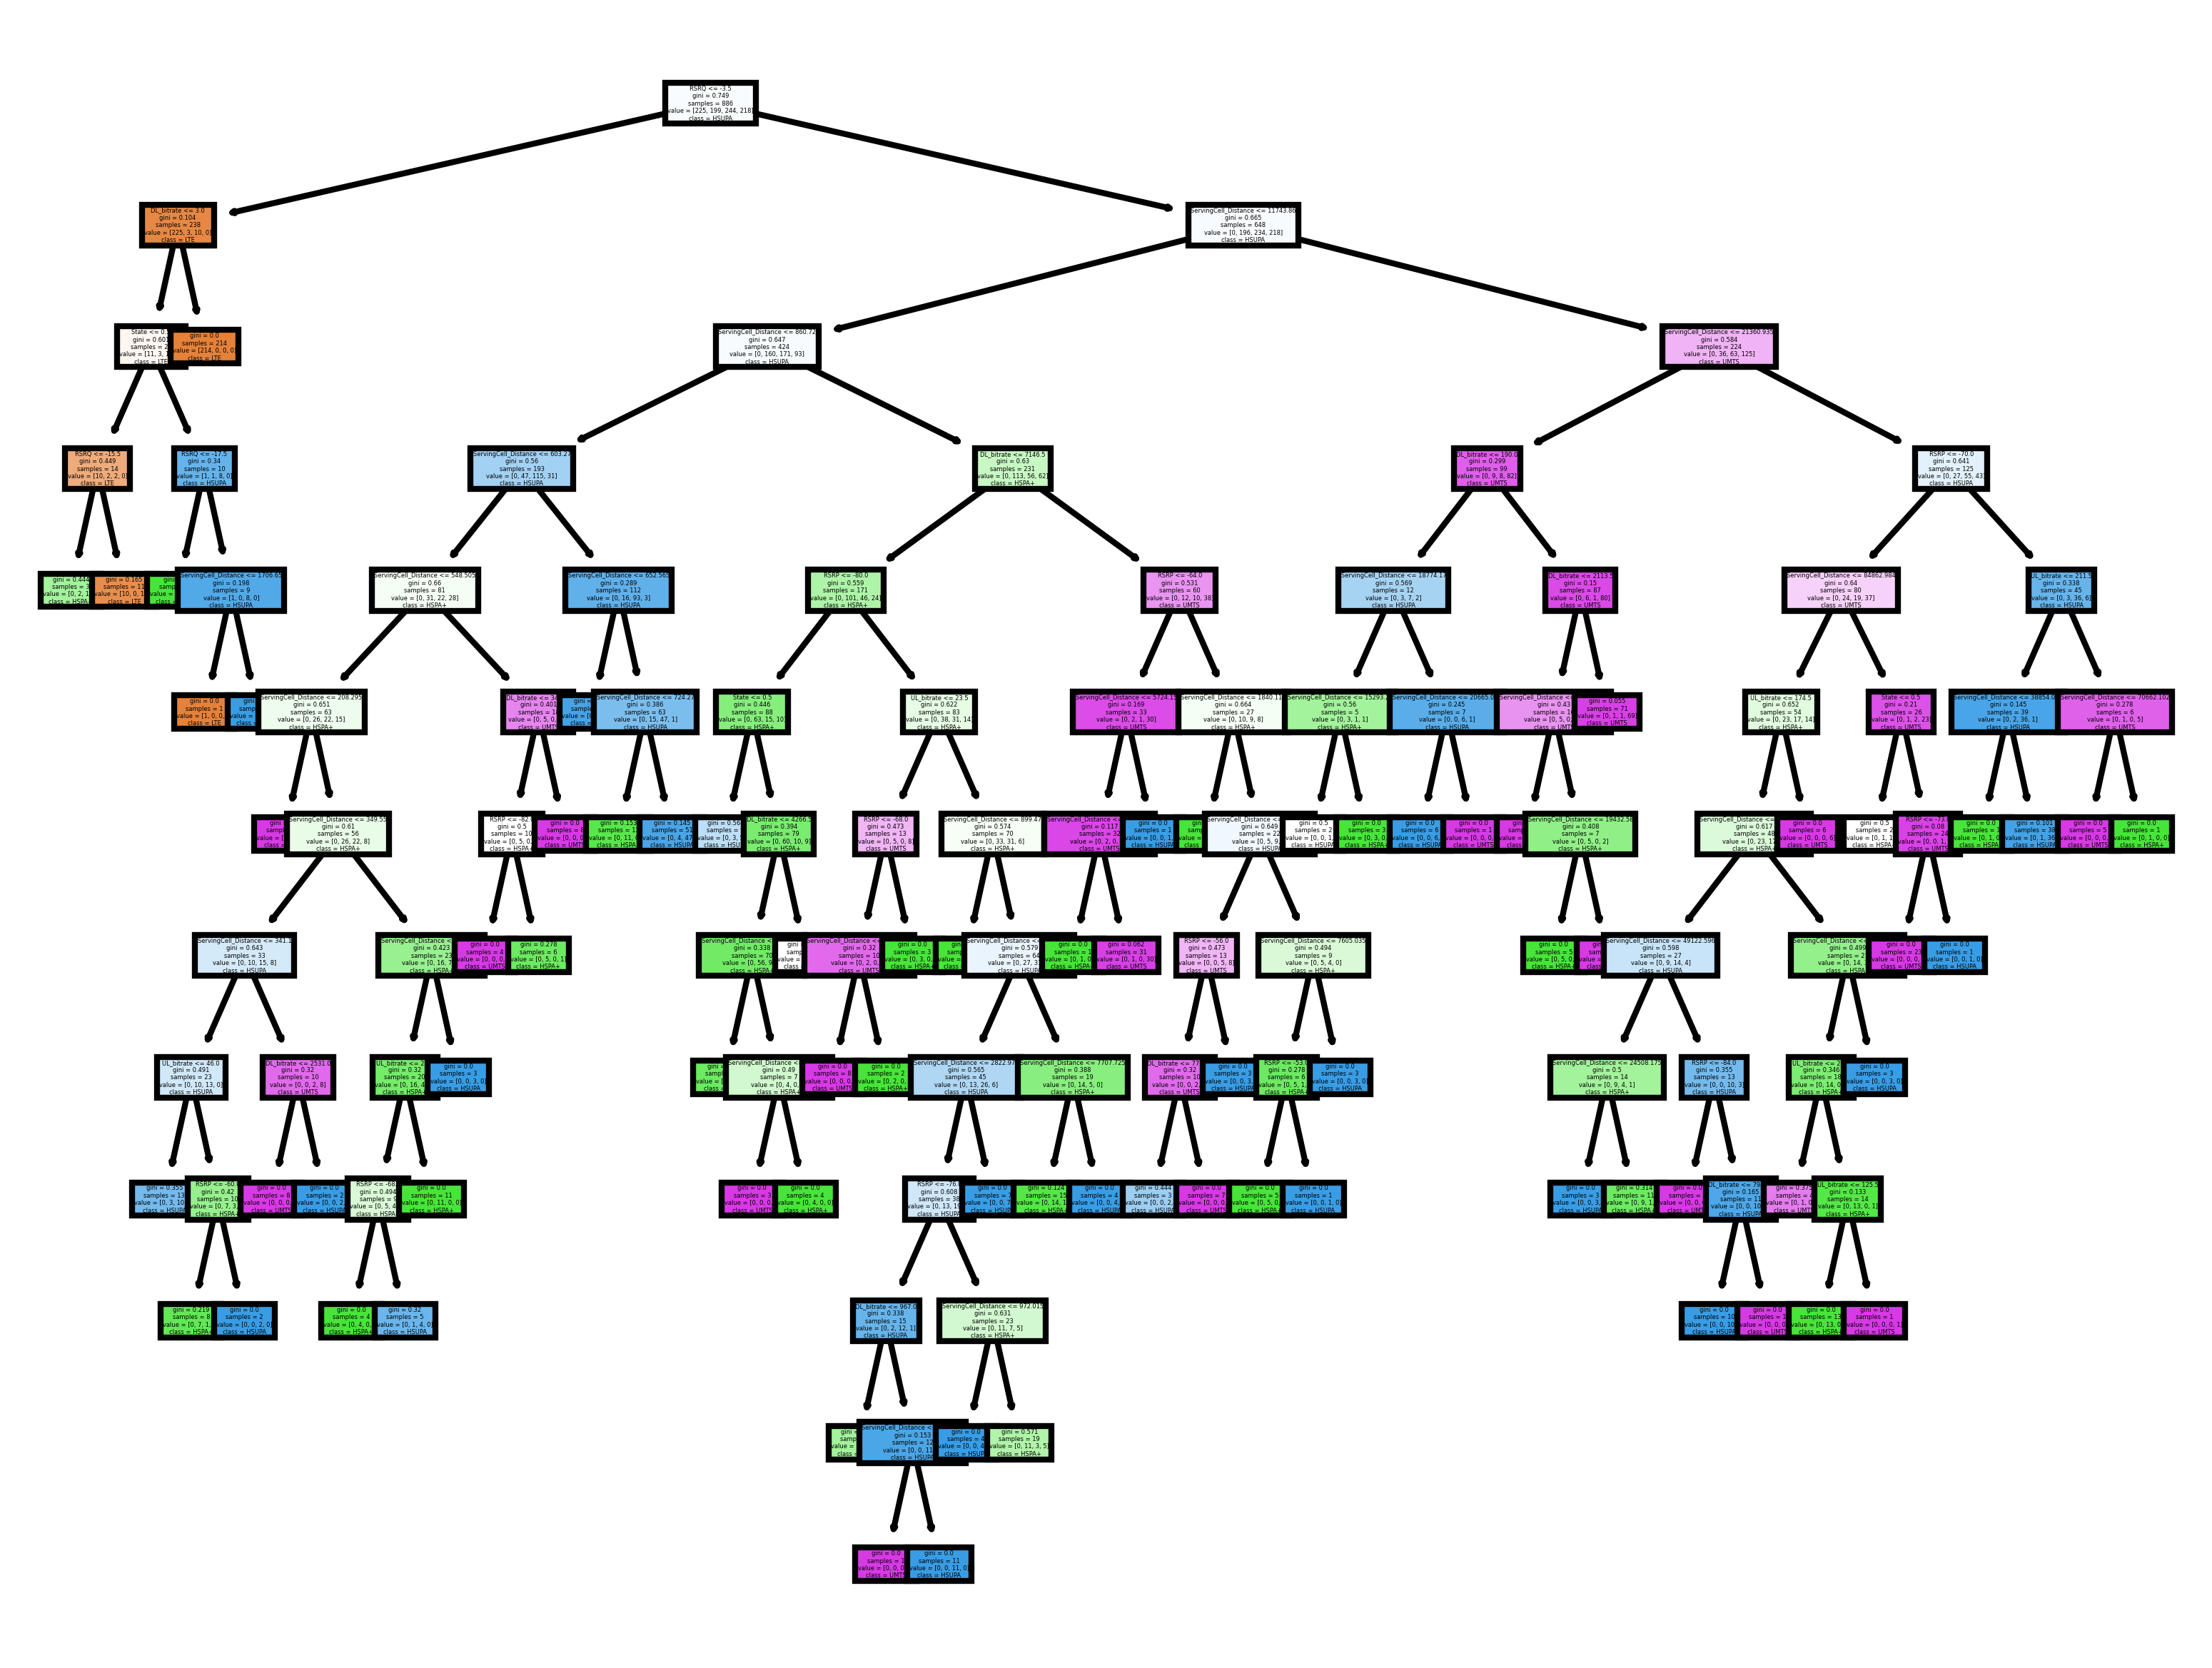

In [57]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, dpi = 600)
plot_tree(tr,feature_names = features,
         class_names = ['LTE', 'HSPA+', 'HSUPA', 'UMTS'],
         filled = True);

RSRQ seems to be the most important question in the decision tree
Took 'Speed' out of the features for all models and performnace noticably dropped for all models. An intersting observation given it should not have an effect on RF classification but makes sense when having to detect inreal time for distnace and power loss considerations.